<a href="https://colab.research.google.com/github/chun-ming-Lin/Kaggle---Tabular-Playground-Series---Jan-2021/blob/master/2021JAN_BaseModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import module

In [1]:
from sklearn.linear_model import Lasso, BayesianRidge, Ridge
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge # 跟SVR相似，但是KRR損失函數使用平方差
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.ensemble import VotingRegressor, RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from lightgbm.sklearn import LGBMRegressor
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
from sklearn.preprocessing import Normalizer, StandardScaler

In [2]:
data_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/tabular_2021_Jan/train.csv', index_col='id')
sub_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/tabular_2021_Jan/test.csv', index_col='id')
submission_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/tabular_2021_Jan/sample_submission.csv', index_col='id')
print(data_df.shape, sub_df.shape)
data_df[:2]

(300000, 15) (200000, 14)


,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,target
id,,,,,,,,,,,,,,,
1,0.670390,0.811300,0.643968,0.291791,0.284117,0.855953,0.890700,0.285542,0.558245,0.779418,0.921832,0.866772,0.878733,0.305411,7.243043
3,0.388053,0.621104,0.686102,0.501149,0.643790,0.449805,0.510824,0.580748,0.418335,0.432632,0.439872,0.434971,0.369957,0.369484,8.203331


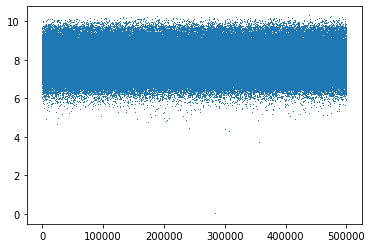

In [3]:
plt.plot(data_df['target'], ',')

# Preprocessing data

In [4]:
# split target
data_target = data_df.pop('target')

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    data_df, data_target, test_size=0.3, random_state=1234
)

In [6]:
# drop outlier
def drop_outlier(X, y):
  outlier = y[y<4].index
  X = X.drop(outlier, axis=0)
  y = y.drop(outlier, axis=0)
  return X, y
X_train, y_train = drop_outlier(X_train, y_train)
X_train.shape, y_train.shape
data_df, data_target = drop_outlier(data_df, data_target)
data_df.shape, data_target.shape

((299998, 14), (299998,))

In [12]:
def preprocessing(data):
  scaler = StandardScaler()
  data = scaler.fit_transform(data)
  return data
X_train = preprocessing(X_train)
X_test = preprocessing(X_test)
data_df = preprocessing(data_df)
sub_df = preprocessing(sub_df)

# Define and fit model

In [22]:
lasso = Lasso(alpha=0.01)
bayesian_ridge = BayesianRidge()
ridge = Ridge(alpha=0.01)
xgbr = XGBRegressor(objective='reg:squarederror', eval_metric='rmse')
# svr = SVR()  # 較慢
# kernel_ridge = KernelRidge(alpha=0.1)
# k_neighbor = KNeighborsRegressor()
# r_neighbor = RadiusNeighborsRegressor()
model_members = [lasso, bayesian_ridge, ridge, xgbr]

In [23]:
def train_fit_model(X_train, y_train, X_test, y_test):
  for model in model_members:
    model.fit(X_train, y_train)
    y_hat = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_hat, squared=False)
    print(str(model), ' RMSE:', rmse)

In [24]:
train_fit_model(X_train, y_train, X_test, y_test)

Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)  RMSE: 0.7311081208498293
BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, alpha_init=None,
              compute_score=False, copy_X=True, fit_intercept=True,
              lambda_1=1e-06, lambda_2=1e-06, lambda_init=None, n_iter=300,
              normalize=False, tol=0.001, verbose=False)  RMSE: 0.7245234007875174
Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)  RMSE: 0.7245199117356543
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='rmse',
             gamma=0, importance_type='gain', learning_rate=0.1,
             max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
             n_estimators=100, n_jobs=1, nth

# Use XgboostRegression model

In [13]:
xgbr = XGBRegressor(
    booster='gbtree',
    eta=0.01,
    max_depth=12,
    subsample=0.8,   # like dropout layer
    # sampling_method='gradient_based',
    max_bin=400,
    num_parallel_tree=10,
    tree_method='gpu_hist',
    grow_policy='lossguide',
    min_child_weight=100,
    deterministic_histogram=False,
    objective='reg:squarederror',
    eval_metric='rmse',
    seed=1234,
)
xgbr.fit(X_train, y_train, verbose=1)
y_hat_xgbr = xgbr.predict(X_test)
rmse = mean_squared_error(y_test, y_hat_xgbr, squared=False)
print('RMSE:%.5f' %rmse)

RMSE:0.69636


# Use LightGBM

In [14]:
lgbr = LGBMRegressor(
    boosting_type='gbdt',
    max_depth=7,
    learning_rate=0.1,
    n_estimators=600,
    subsample_for_bin=20000,
    min_child_weight=300,
    min_split_gain=0,
    subsample=0.8,
    random_state=1234,
    n_jobs=5,
)
lgbr.fit(X_train, y_train, verbose=1)
y_hat_lgbr = lgbr.predict(X_test)
rmse = mean_squared_error(y_test, y_hat_lgbr, squared=False)
print('RMSE:%.5f' %rmse)

RMSE:0.69807


In [15]:
y_hat =  (y_hat_xgbr + y_hat_lgbr) / 2
rmse = mean_squared_error(y_test, y_hat, squared=False)
print('RMSE:%.5f' %rmse)

RMSE:0.69637


# Make a submission

In [17]:
def Submission(submission, target):
  submission['target'] = target
  submission.to_csv('Submission.csv')

xgbr_final = xgbr
lgbr_final = lgbr
# fit
xgbr_final.fit(data_df, data_target)
lgbr_final.fit(data_df, data_target)
# predict
y_1 = xgbr_final.predict(sub_df)
y_2 = lgbr_final.predict(sub_df)
target = (y_1 + y_2) / 2

Submission(submission_df, target)

# Ensemble model

In [18]:
# stacking
# list of (str, estimator) tuples
estimators = [
  ('xgbr', xgbr),
  ('lgbr', lgbr)
]

ensemble_model = VotingRegressor(estimators)


In [19]:
ensemble_model.fit(
    X_train, y_train
)
en_yhat = ensemble_model.predict(X_test)
rmse = mean_squared_error(y_test, en_yhat, squared=False)
mse = mean_squared_error(y_test, en_yhat)
print(' mse: %.5f \nrmse: %.5f' %(mse, rmse))

 mse: 0.48493 
rmse: 0.69637


# Make a submission

In [ ]:
def Submission(submission, target):
  submission['target'] = target
  submission.to_csv('Submission.csv')

target = ensemble_model.predict(sub_df)
Submission(submission_df, target)